In [3]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 49.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


**Univariate time series analysis using autoarima**

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [4]:
from google.colab import drive

In [212]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
df=pd.read_csv('/content/drive/MyDrive/ma_lga_12345.csv')

In [214]:
df=df[df.type=='house'] #Let's limit the scope of this problem to houses only
df['saledate'] = pd.to_datetime(df['saledate'])
df.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,saledate,MA,type,bedrooms
195,2018-09-30,1007114,house,5
196,2018-12-31,1002323,house,5
197,2019-03-31,998136,house,5
198,2019-06-30,995363,house,5
199,2019-09-30,970268,house,5


In [215]:
df.rename(columns={'MA':'price'}, inplace=True)
df.head()

,saledate,price,type,bedrooms
0,2007-09-30,441854,house,2
1,2007-12-31,441854,house,2
2,2008-03-31,441854,house,2
3,2008-06-30,441854,house,2
4,2008-09-30,451583,house,2


In [216]:
#Pivot the data so we can feed it into the model
df=df.pivot(index='saledate', columns='bedrooms', values='price').interpolate(method='linear', limit_direction='both')
df.head(),df.tail()


(bedrooms           2         3         4         5
 saledate                                          
 2007-03-31  441854.0  421291.0  548969.0  735904.0
 2007-06-30  441854.0  421291.0  548969.0  735904.0
 2007-09-30  441854.0  421291.0  548969.0  735904.0
 2007-12-31  441854.0  421291.0  548969.0  735904.0
 2008-03-31  441854.0  416031.0  552484.0  735904.0,
 bedrooms           2         3         4          5
 saledate                                           
 2018-09-30  504318.0  624602.0  830727.0  1007114.0
 2018-12-31  506001.0  626608.0  820924.0  1002323.0
 2019-03-31  496133.0  628423.0  811121.0   998136.0
 2019-06-30  500158.0  630814.0  803925.0   995363.0
 2019-09-30  510712.0  631875.0  791446.0   970268.0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbed5435890>,
      dtype=object)

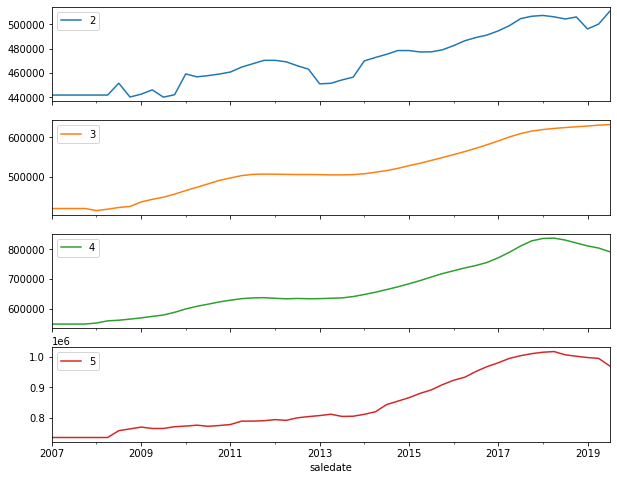

In [217]:
df.plot(subplots=True)

In [218]:
import pmdarima as pm

model = pm.auto_arima(df[2], 
                        m=4, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=1001.200, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=997.370, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1001.125, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1001.273, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=999.053, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=999.199, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=999.199, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=999.300, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=999.447, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1001.400, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4] intercept
Total fit time: 0.690 seconds


In [219]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -496.685
Date:                Mon, 28 Mar 2022   AIC                            997.370
Time:                        12:27:33   BIC                           1001.194
Sample:                             0   HQIC                           998.826
                                 - 51                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1377.1600    706.047      1.951      0.051      -6.666    2760.986
sigma2      2.488e+07   3.29e+06      7.558      0.000    1.84e+07    3.13e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                13.93
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.09
Prob(H) (two-sided):                  0.16   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df, test_size=0.10,shuffle=False)


In [221]:
test

bedrooms,2,3,4,5
saledate,,,,
2018-06-30,506116.0,622466.0,837295.0,1017752.0
2018-09-30,504318.0,624602.0,830727.0,1007114.0
2018-12-31,506001.0,626608.0,820924.0,1002323.0
2019-03-31,496133.0,628423.0,811121.0,998136.0
2019-06-30,500158.0,630814.0,803925.0,995363.0
2019-09-30,510712.0,631875.0,791446.0,970268.0


In [222]:
test2=test[2]
test2

saledate
2018-06-30    506116.0
2018-09-30    504318.0
2018-12-31    506001.0
2019-03-31    496133.0
2019-06-30    500158.0
2019-09-30    510712.0
Name: 2, dtype: float64

In [223]:
train2=train[2]
train2

saledate
2007-03-31    441854.0
2007-06-30    441854.0
2007-09-30    441854.0
2007-12-31    441854.0
2008-03-31    441854.0
2008-06-30    441854.0
2008-09-30    451583.0
2008-12-31    440256.0
2009-03-31    442566.0
2009-06-30    446113.0
2009-09-30    440123.0
2009-12-31    442131.0
2010-03-31    459222.0
2010-06-30    456822.0
2010-09-30    457806.0
2010-12-31    459109.0
2011-03-31    460758.0
2011-06-30    464788.0
2011-09-30    467546.0
2011-12-31    470333.0
2012-03-31    470365.0
2012-06-30    469149.0
2012-09-30    465919.0
2012-12-31    463090.0
2013-03-31    451077.0
2013-06-30    451516.0
2013-09-30    454270.0
2013-12-31    456548.0
2014-03-31    469920.0
2014-06-30    472726.0
2014-09-30    475326.0
2014-12-31    478413.0
2015-03-31    478398.0
2015-06-30    477238.0
2015-09-30    477330.0
2015-12-31    479010.0
2016-03-31    482440.0
2016-06-30    486436.0
2016-09-30    489104.0
2016-12-31    491152.0
2017-03-31    494544.0
2017-06-30    498846.0
2017-09-30    504592.0
20

In [241]:
model.fit(train2)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True)

In [225]:
forecast=model.predict(n_periods=6,return_conf_int=False)

In [226]:
forecast

array([508734.22727273, 510220.45454545, 511706.68181818, 513192.90909091,
       514679.13636364, 516165.36363636])

In [253]:
pred2 = pd.DataFrame(index=test2.index, data=forecast)
pred2

,0
saledate,
2018-06-30,508734.227273
2018-09-30,510220.454545
2018-12-31,511706.681818
2019-03-31,513192.909091
2019-06-30,514679.136364
2019-09-30,516165.363636


In [254]:
test2


saledate
2018-06-30    506116.0
2018-09-30    504318.0
2018-12-31    506001.0
2019-03-31    496133.0
2019-06-30    500158.0
2019-09-30    510712.0
Name: 2, dtype: float64

In [255]:
test2.mean()

503906.3333333333

In [256]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse2=sqrt(mean_squared_error(test2,pred2))

print('2 bedrooms rmse',rmse2)


2 bedrooms rmse 10048.97974220076


In [257]:
#MAPE
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape2=mean_absolute_percentage_error(test2,pred2)
print('2 bedrooms',mape2)


2 bedrooms 1.7310271772561687


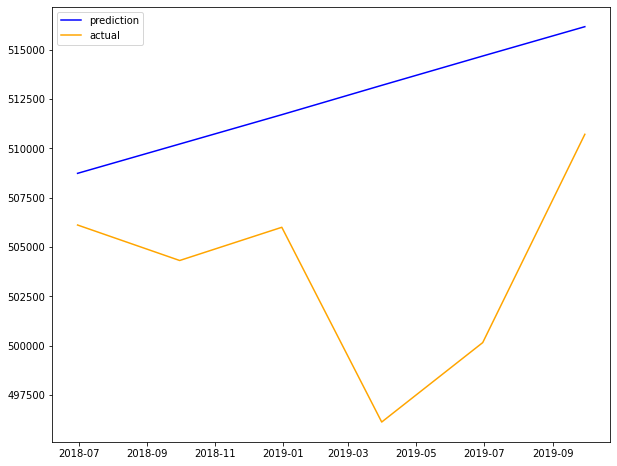

In [258]:
plt.plot(pred2, color='blue', label='prediction')
plt.plot(test2, color= 'orange', label= 'actual')
plt.legend(loc='best')


In [313]:
# Forecasting 4 future qarters
forecast1=model.predict(n_periods=4, return_conf_int=False,)
forecast_range=pd.date_range(start='2019-09-30', periods=4,freq='Q')
future = pd.DataFrame(index=forecast_range,data=forecast1)
future.astype(int)

,0
2019-09-30,624145
2019-12-31,628653
2020-03-31,633161
2020-06-30,637669


**FOR 3 BEDROOMS, REPEATING SAME PROCESS**

In [260]:
# only taking column for 3 bedroom
model3 = pm.auto_arima(df[3], 
                        m=4, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1257.793, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1282.082, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1489.734, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=1255.966, Time=0.03 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=1250.750, Time=0.05 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=1252.700, Time=0.12 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=999.846, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=1011.080, Time=0.17 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=1000.637, Time=0.43 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=1002.385, Time=0.18 sec
 ARIMA(2,0,0)(0,0,2)[4] intercept   : AIC=940.545, Time=0.28 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=939.335, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=948.

In [261]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df, test_size=0.10,shuffle=False)


In [262]:
test3=test[3]
test3

saledate
2018-06-30    622466.0
2018-09-30    624602.0
2018-12-31    626608.0
2019-03-31    628423.0
2019-06-30    630814.0
2019-09-30    631875.0
Name: 3, dtype: float64

In [263]:
train3=train[3]

In [287]:
model3.fit(train3)

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 0, 1, 4),
      suppress_warnings=True)

In [289]:
forecast3=model3.predict(n_periods=6,return_conf_int=False)

In [290]:
pred3 = pd.DataFrame(index=test3.index, data=forecast3)
pred3

,0
saledate,
2018-06-30,622089.519491
2018-09-30,624195.295262
2018-12-31,626090.532406
2019-03-31,627868.152680
2019-06-30,629169.506269
2019-09-30,629994.159193


In [291]:
test3

saledate
2018-06-30    622466.0
2018-09-30    624602.0
2018-12-31    626608.0
2019-03-31    628423.0
2019-06-30    630814.0
2019-09-30    631875.0
Name: 3, dtype: float64

In [292]:
#RMSE
rmse3=sqrt(mean_squared_error(test3,pred3))

print('3 bedrooms rmse',rmse3)


3 bedrooms rmse 1089.701514811194


In [293]:
test3.mean()

627464.6666666666

In [294]:
#MAPE
mape3=mean_absolute_percentage_error(test3,pred3)
print('3 bedrooms',mape3)

3 bedrooms 0.5784431046247668


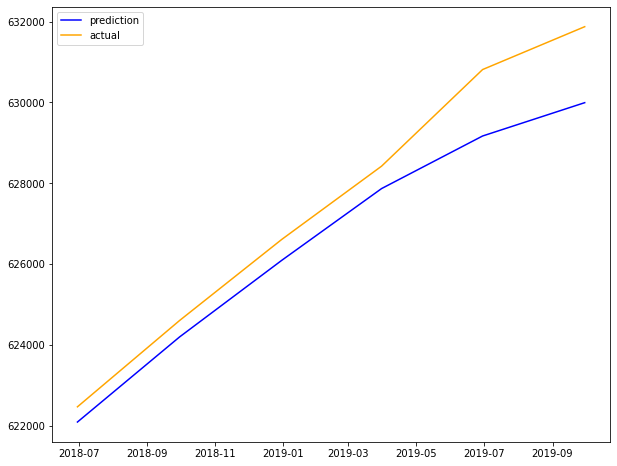

In [295]:
plt.plot(pred3, color='blue', label='prediction')
plt.plot(test3, color= 'orange', label= 'actual')
plt.legend(loc='best')

In [312]:
# Forecasting 4 future qarters
forecast3=model.predict(n_periods=4, return_conf_int=False,)
forecast_range=pd.date_range(start='2019-09-30', periods=4,freq='Q')
future3 = pd.DataFrame(index=forecast_range,data=forecast3)
future3.astype(int)

,0
2019-09-30,624145
2019-12-31,628653
2020-03-31,633161
2020-06-30,637669


**FOR 4 BEDROOMS**

In [277]:
# only taking column for 4 bedroom
model4 = pm.auto_arima(df[4], 
                        m=4, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=930.422, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=926.386, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=931.475, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=930.911, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=928.352, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=928.552, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=929.506, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[4]             : AIC=928.938, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=931.344, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=928.020, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[4]          
Total fit time: 0.400 seconds


In [278]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df, test_size=0.10,shuffle=False)


In [282]:
test4=test[4]


In [283]:
train4=train[4]


In [296]:
model4.fit(train4)

ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True, with_intercept=False)

In [298]:
forecast4=model4.predict(n_periods=6,return_conf_int=False)
pred4 = pd.DataFrame(index=test4.index, data=forecast4)
pred4

,0
saledate,
2018-06-30,844054.0
2018-09-30,852052.0
2018-12-31,860050.0
2019-03-31,868048.0
2019-06-30,876046.0
2019-09-30,884044.0


In [299]:
test4

saledate
2018-06-30    837295.0
2018-09-30    830727.0
2018-12-31    820924.0
2019-03-31    811121.0
2019-06-30    803925.0
2019-09-30    791446.0
Name: 4, dtype: float64

In [305]:
#RMSE
rmse4=sqrt(mean_squared_error(test4,pred4))

print('4 bedrooms rmse',rmse4)


4 bedrooms rmse 56343.8774491071


In [301]:
test4.mean()

815906.3333333334

In [303]:
#MAPE
mape4=mean_absolute_percentage_error(test4,pred4)
print('4 bedrooms',mape4)

4 bedrooms 5.939543580697498


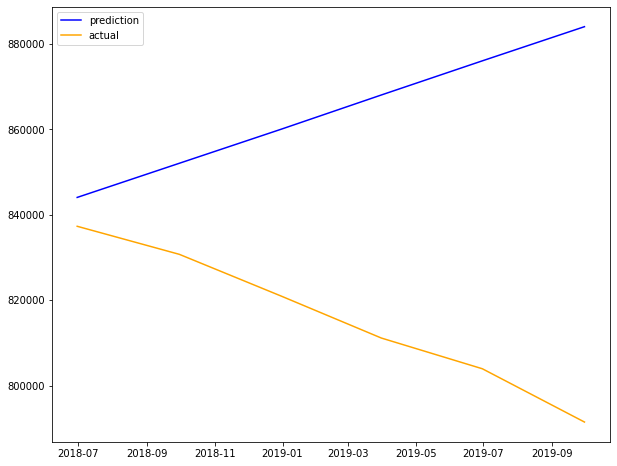

In [304]:
plt.plot(pred4, color='blue', label='prediction')
plt.plot(test4, color= 'orange', label= 'actual')
plt.legend(loc='best')

In [311]:
# Forecasting 4 future qarters
forecast4=model.predict(n_periods=4, return_conf_int=False,)
forecast_range=pd.date_range(start='2019-09-30', periods=4,freq='Q')
future4 = pd.DataFrame(index=forecast_range,data=forecast4)
future4.astype(int)

,0
2019-09-30,624145
2019-12-31,628653
2020-03-31,633161
2020-06-30,637669


**FOR 5 BEDROOMS**

In [314]:
# only taking column for 5 bedroom
model5 = pm.auto_arima(df[5], 
                        m=4, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=1023.336, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=1018.635, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=1023.062, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=1022.770, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=1020.694, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=1020.915, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=1021.066, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[4]             : AIC=1020.773, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=1022.201, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[4] intercept   : AIC=1020.380, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[4]          
Total fit time: 0.483 seconds


In [315]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df, test_size=0.10,shuffle=False)


In [319]:
test5=test[5]

In [320]:
train5=train[5]


In [321]:
model5.fit(train5)

ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True, with_intercept=False)

In [323]:
forecast5=model5.predict(n_periods=6,return_conf_int=False)
pred5 = pd.DataFrame(index=test5.index, data=forecast5)
pred5

,0
saledate,
2018-06-30,1020210.0
2018-09-30,1024891.0
2018-12-31,1029572.0
2019-03-31,1034253.0
2019-06-30,1038934.0
2019-09-30,1043615.0


In [324]:
test4

saledate
2018-06-30    837295.0
2018-09-30    830727.0
2018-12-31    820924.0
2019-03-31    811121.0
2019-06-30    803925.0
2019-09-30    791446.0
Name: 4, dtype: float64

In [326]:
#RMSE
rmse5=sqrt(mean_squared_error(test5,pred5))

print('5 bedrooms rmse',rmse5)

5 bedrooms rmse 40098.26187629584


In [327]:
test5.mean()

998492.6666666666

In [328]:
#MAPE
mape5=mean_absolute_percentage_error(test5,pred5)
print('5 bedrooms',mape5)

5 bedrooms 3.3691763972825424


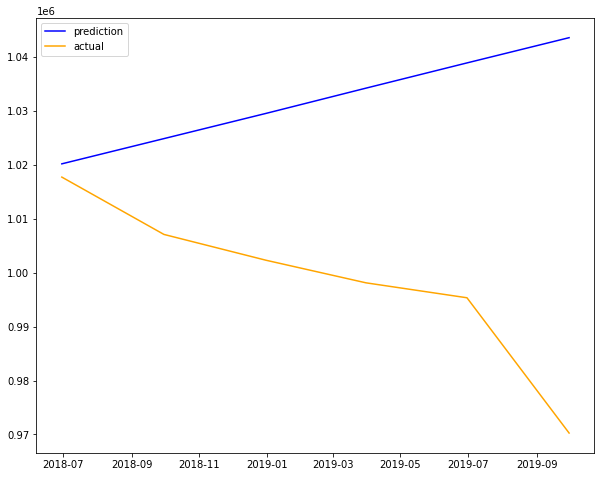

In [329]:
plt.plot(pred5, color='blue', label='prediction')
plt.plot(test5, color= 'orange', label= 'actual')
plt.legend(loc='best')

In [330]:
# Forecasting 4 future qarters
forecast5=model.predict(n_periods=4, return_conf_int=False,)
forecast_range=pd.date_range(start='2019-09-30', periods=4,freq='Q')
future5 = pd.DataFrame(index=forecast_range,data=forecast5)
future5.astype(int)

,0
2019-09-30,624145
2019-12-31,628653
2020-03-31,633161
2020-06-30,637669
